# PIPELINE

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np 
import os

import vip_hci as vip
from vip_hci.fits import open_fits
from main import (shift_and_crop_cube, 
                  fit_and_crop, 
                  frame_center, 
                  get_square, 
                  fit_gaussian_2d, 
                  recenter_cube, 
                  normalize_psf)
from vip.pca import reduce_pca
from vip.detection import get_intersting_coords
from vip.loss import inject_fcs_cube_mod

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

%load_ext autoreload
%autoreload 2

2023-05-16 16:16:22.938940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 16:16:24.017240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-16 16:16:24.017322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/users/cdonoso/miniconda3/envs/tf2/lib/p

## LOADING DATA

In [2]:
root = './data/HCI/'
cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

# lam_route   = os.path.join(root, 'lam.fits')
# lambdas_inf = open_fits(lam_route, header=False)

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 90, 201, 201)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (90,)


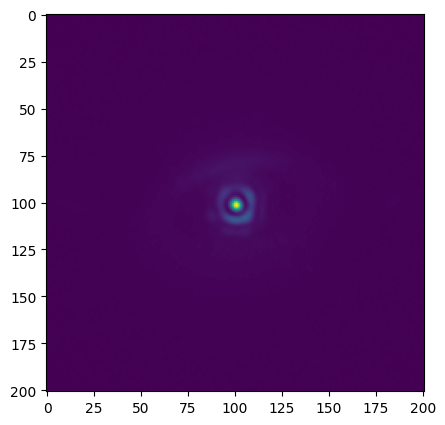

In [3]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(cube[0, 0])

In [4]:
def modify_shape_and_center(img, shift_h=1, shift_w=1):
    # Get the height and width of the image
    height, width = img.shape[:2]

    # Increase the image size by 1 pixel
    new_height = height + shift_h
    new_width = width + shift_w

    # Create a new image with the increased size
    new_img = np.zeros((new_height, new_width))

    # Calculate the offset needed to center the original image in the new image
    x_offset = int((new_width - width) / 2)
    y_offset = int((new_height - height) / 2)

    # Copy the original image into the center of the new image
    new_img[y_offset:y_offset+height, x_offset:x_offset+width] = img

    return new_img

In [5]:
psf_even = []
for curr_psf in psf[lambda_ch]:
    psf_even.append(modify_shape_and_center(curr_psf, shift_h=1, shift_w=1)) 
psf_even = np.array(psf_even)

Text(0.5, 1.0, '(2, 65, 65)')

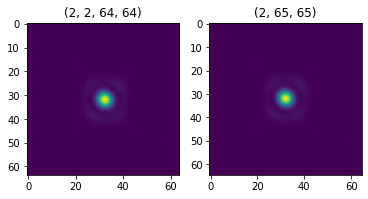

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(psf[lambda_ch, 0])
axes[0].set_title(psf.shape)

im = axes[1].imshow(psf_even[0])
axes[1].set_title(psf_even.shape)

## Normalize PSF

In [7]:
psf[lambda_ch].shape

(2, 64, 64)

`Size` is even (while input frame size is odd). Setting `size` to 31 pixels
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-16 16:16:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
`subi_size` is odd (while frame size is even)
Setting `subi_size` to 8 pixels
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.230786
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


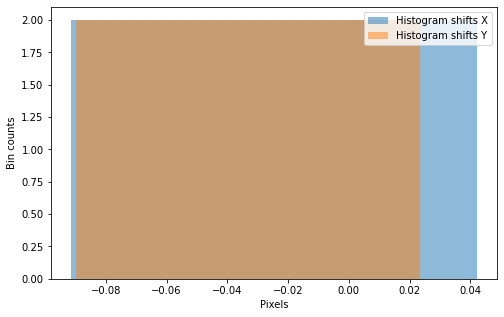

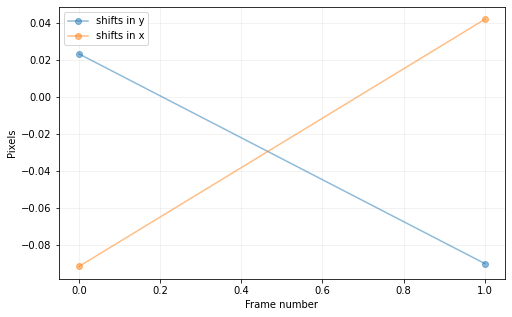

In [8]:
single_psf = psf[lambda_ch, psf_pos, :-1, :-1]
ceny, cenx = frame_center(single_psf)
imside = single_psf.shape[0]
cropsize = 30

fit = vip.var.fit_2dgaussian(single_psf, 
                             crop=True, 
                             cropsize=30, 
                             debug=False, 
                             full_output=True) 
fwhm_sphere = np.mean([fit.fwhm_y,fit.fwhm_x]) 

y_cent, x_cent = frame_center(single_psf) 
y_c=int(y_cent)
x_c=int(x_cent)
psf_center = vip.preproc.recentering.cube_recenter_2dfit(psf[lambda_ch], (y_c, x_c), 
                                                                       fwhm_sphere,model='gauss',
                                                                       nproc=8, subi_size=7, negative=False,
                                                                       full_output=False, 
                                                                       debug=False)

In [9]:
psf_norm, fwhm_flux, fwhm = normalize_psf(psf_center, 
                                         fwhm=fwhm_sphere, 
                                         size=None, 
                                         threshold=None, 
                                         mask_core=None,
                                         full_output=True, 
                                         verbose=True) 

`Force_odd` is True and frame size is even, therefore new frame size was set to 63
Flux in 1xFWHM aperture: 
[130696.559 122361.464]


## Angular Differential Imaging (ADI)

In [10]:
%%time
fr_pca = vip.psfsub.pca(cube[0], 
                            rot_ang,
                            svd_mode='eigencupy', 
                            full_output=False,
                            imlib='opencv') #pca image of the system

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-16 16:16:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 270.406 GB
System available memory = 221.725 GB
Done vectorizing the frames. Matrix shape: (90, 40401)
Done PCA with cupy eigh function (GPU)
Running time:  0:00:02.767792
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:03.086851
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
CPU times: user 2.18 s, sys: 872 ms, total: 3.05 s
Wall time: 3.09 s


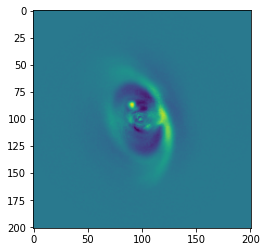

In [11]:
plt.imshow(fr_pca)

## Detection

In [12]:
res = vip.metrics.detection(fr_pca, fwhm=fwhm[0], psf=psf_norm[0], bkg_sigma=5, snr_thresh=2, 
                            debug=False, plot=False, verbose=True, full_output=True)

Blobs found: 2
 ycen   xcen
------ ------
87.124 	 90.708
99.917 	 89.227

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (90.7,87.1)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 90.7, 87.1
Flux in a centered 1xFWHM circular aperture = 47.294
Central pixel S/N = 2.607
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 1.983
Max S/N (shifting the aperture center) = 2.624
stddev S/N (shifting the aperture center) = 0.410


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (89.2,99.9)
S/N constraint NOT fulfilled (S/N = 1.370)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [14]:
res

,y,x,px_snr
0,87.124295,90.707752,2.607060
1,99.916672,89.227077,1.370171


## Optimizing

In [15]:
psf_norm.shape

(2, 63, 63)

In [16]:
%%time
results = vip.fm.negfc_simplex.firstguess(cube[0], 
                                          angs=rot_ang,       
                                          psfn=psf_norm[0], 
                                          ncomp=1, 
                                          planets_xy_coord=[(res.iloc[0]['y'], res.iloc[0]['x'])],
                                          imlib='opencv',
                                          fwhm=fwhm[0],
                                          simplex=True,
                                          annulus_width=4*fwhm[0],
                                          aperture_radius=2,
                                         algo_options={
                                             'nproc': 32,
                                             'imlib': 'opencv'
                                         })

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-05-16 16:19:47
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [87.12429465591156,90.70775238923589], running ...
Step | flux    | chi2r
1/30   0.100   168.597
2/30   0.149   168.640
3/30   0.221   168.704
4/30   0.329   168.800
Planet 0: preliminary guess: (r, theta, f)=(15.9, 215.8, 0.1)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 155, nfev: 301, chi2r: 123.65789031982422
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(15.691, 233.934, 56.798) at 
          (X,Y)=(90.76, 87.32)

 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

In [17]:
radius_fguess = results[0][0]
theta_fguess  = results[1][0]
flux_fguess   = results[2][0]

In [18]:
centy_fr, centx_fr = frame_center(cube[0])
posy = radius_fguess * np.sin(np.deg2rad(theta_fguess)) + centy_fr
posx = radius_fguess * np.cos(np.deg2rad(theta_fguess)) + centx_fr
posx,posy, flux_fguess

(90.76226955666465, 87.31606874815091, 56.79839311968223)

(30.76226955666465, 150.76226955666465)

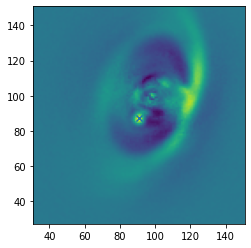

In [19]:
plt.figure()
plt.imshow(fr_pca)
plt.scatter(posx, posy, marker='x')
plt.ylim(posy-60, posx+60)
plt.xlim(posx-60, posx+60)

## Visualizing results

In [20]:
from vip_hci.fm.negfc_fmerit import cube_inject_companions

In [21]:
cube_negfc = cube_inject_companions(np.zeros_like(cube[0]), psf_norm, rot_ang, flevel=flux_fguess,
                                    rad_dists=[radius_fguess], plsc=1.2, n_branches=1,
                                    theta=theta_fguess, verbose=False)

adi_fake = reduce_pca(cube_negfc, rot_angles=rot_ang)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
fig, axes = plt.subplots(1, 3, dpi=200, sharex=True, sharey=True)
axes[0].imshow(fr_pca)
axes[1].imshow(adi_fake)
axes[2].imshow(fr_pca-adi_fake)

### MCMC

In [90]:
from vip_hci.fm.negfc_mcmc import mcmc_negfc_sampling
from multiprocessing import cpu_count
from vip_hci.psfsub import pca_annulus

In [91]:
obs_params = {'psfn': psf_norm, 'fwhm': 4.}

algo_params = {'algo': pca_annulus,
#                'ncomp': 1,
               'annulus_width': obs_params['fwhm']*2,
               'svd_mode': 'lapack',
               'imlib': 'opencv',
               'interpolation': 'lanczos4'}

mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': cpu_count()//2}

conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

In [84]:
initial_state = [radius_fguess, theta_fguess, flux_fguess]
chain = mcmc_negfc_sampling(cube[0], 
                            rot_ang,  
                            psf_norm, 
                            ncomp=1, 
                            plsc=1.2, 
                            initial_state=initial_state,
                            display=True, verbosity=1, 
                            save=False, output_dir='./')

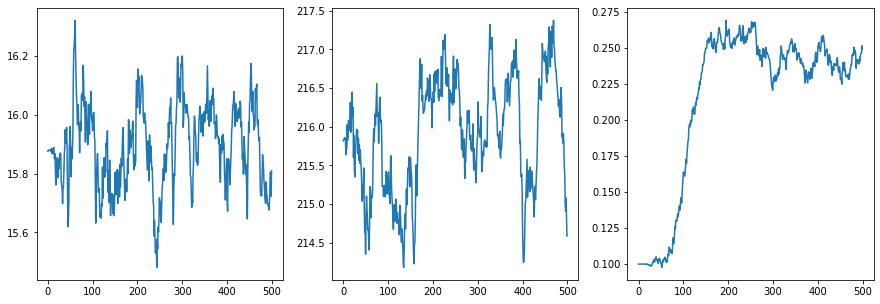

In [111]:
xm = np.mean(chain, 0)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(xm[:, 0])
axes[1].plot(xm[:, 1])
axes[2].plot(xm[:, 2])

In [126]:
radius_star = np.mean(xm[:, 0])
theta_star  = np.mean(xm[:, 1])
flux_star   = np.mean(xm[300:, 2])

centy_fr, centx_fr = frame_center(cube[0])
posy_star = radius_star * np.sin(np.deg2rad(theta_star)) + centy_fr
posx_star = radius_star * np.cos(np.deg2rad(theta_star)) + centx_fr

In [123]:
cube_negfc = cube_inject_companions(np.zeros_like(cube[0]), psf_norm, rot_ang, flevel=-flux_star,
                                    rad_dists=[radius_star], n_branches=1,
                                    theta=theta_star)

adi_fake = reduce_pca(cube_negfc, rot_angles=rot_ang)

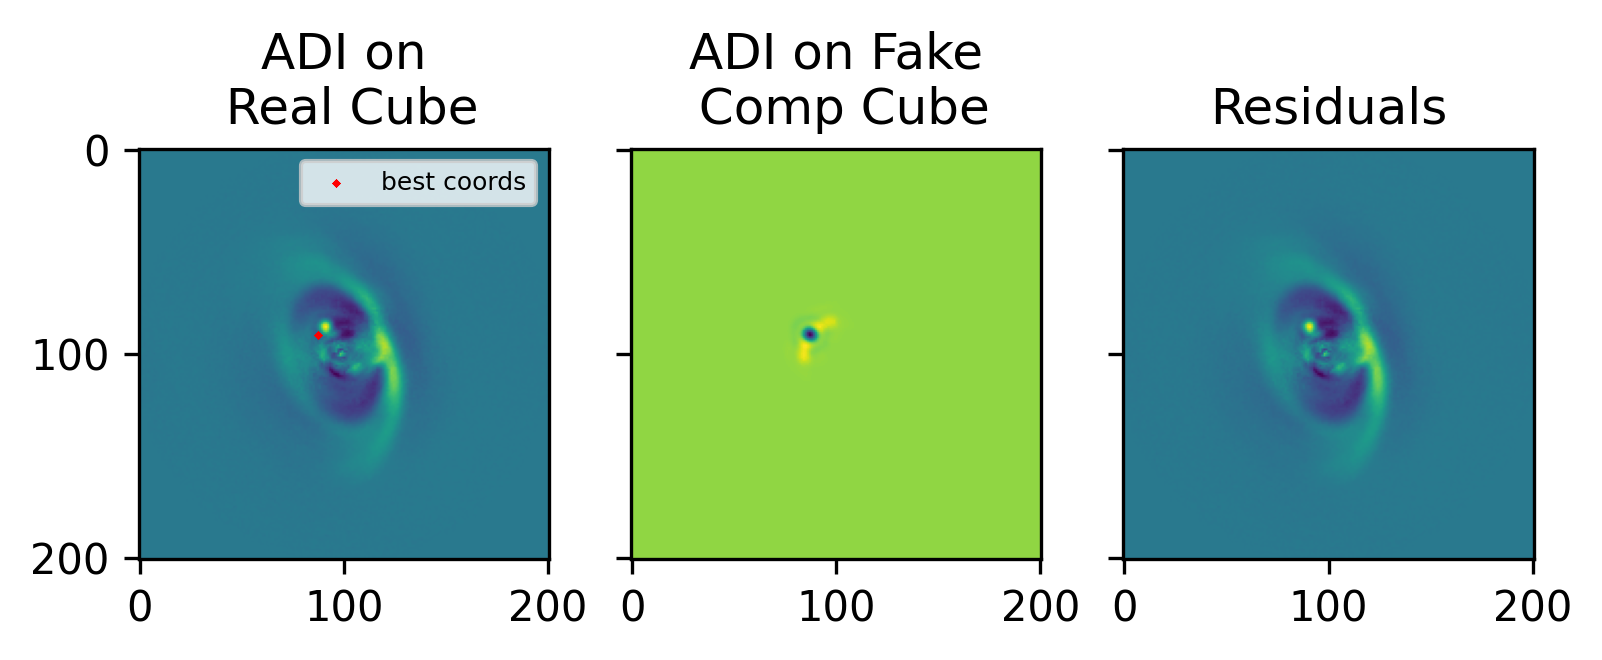

In [150]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(fr_pca)
axes[1].imshow(adi_fake)
axes[1].set_title('ADI on Fake\n Comp Cube')
axes[2].imshow(fr_pca+adi_fake)
axes[2].set_title('Residuals')
axes[0].scatter(posx_star, posy_star, marker='x', s=1, color='r', label='best coords')
axes[0].legend(bbox_to_anchor=(1., 1.), fontsize=6)
axes[0].set_title('ADI on\n Real Cube')
plt.show()